# Modelagem Preditiva – Risco de Rotatividade (Attrition)

Nesta seção, desenvolvemos e comparamos quatro modelos preditivos para estimar a probabilidade de um funcionário pedir desligamento (Attrition = 1). Esse tipo de modelo é essencial para que a área de Recursos Humanos possa agir de forma preventiva, retendo talentos com risco iminente de saída.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, f1_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


In [ ]:
df = pd.read_csv('sample_data/dataset_feature_engineered.csv')

X = df.drop('Attrition', axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)


In [ ]:
def calcular_lift(y_true, y_scores, n_bins=10):
    df_lift = pd.DataFrame({'y_true': y_true, 'score': y_scores})
    df_lift['bin'] = pd.qcut(df_lift['score'], q=n_bins, duplicates='drop')

    lift_table = df_lift.groupby('bin').agg(
        total=('y_true', 'count'),
        positives=('y_true', 'sum')
    ).sort_index(ascending=False).reset_index()

    lift_table['rate'] = lift_table['positives'] / lift_table['total']
    baseline_rate = df_lift['y_true'].mean()
    lift_table['lift'] = lift_table['rate'] / baseline_rate

    return lift_table


/tmp/ipython-input-3-3268581231.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift_table = df_lift.groupby('bin').agg(



🔍 Regressão Logística
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       247
           1       0.37      0.60      0.46        47

    accuracy                           0.78       294
   macro avg       0.64      0.70      0.66       294
weighted avg       0.83      0.78      0.79       294



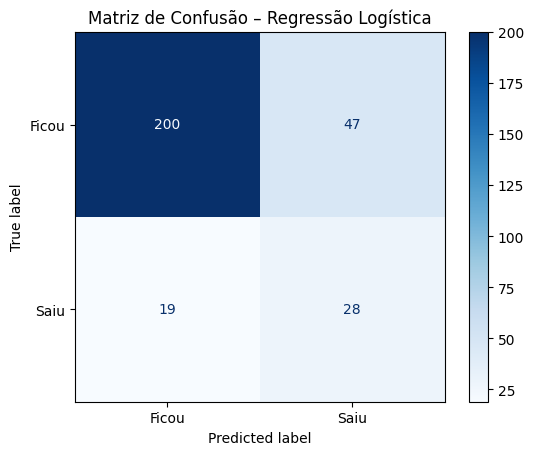

/tmp/ipython-input-3-3268581231.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift_table = df_lift.groupby('bin').agg(



🔍 KNN
              precision    recall  f1-score   support

           0       0.90      0.70      0.78       247
           1       0.26      0.57      0.36        47

    accuracy                           0.68       294
   macro avg       0.58      0.64      0.57       294
weighted avg       0.79      0.68      0.72       294



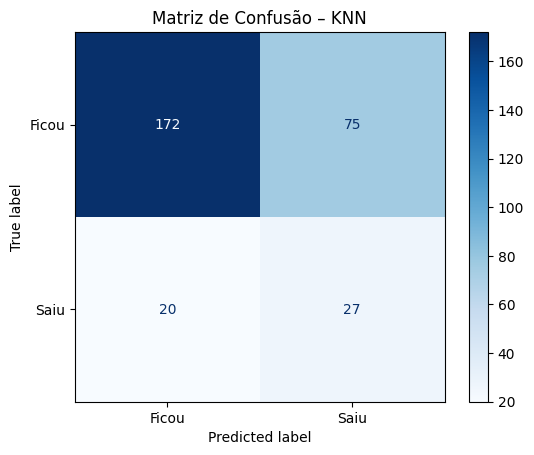

/tmp/ipython-input-3-3268581231.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift_table = df_lift.groupby('bin').agg(



🔍 Árvore de Decisão
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       247
           1       0.38      0.40      0.39        47

    accuracy                           0.80       294
   macro avg       0.63      0.64      0.64       294
weighted avg       0.80      0.80      0.80       294



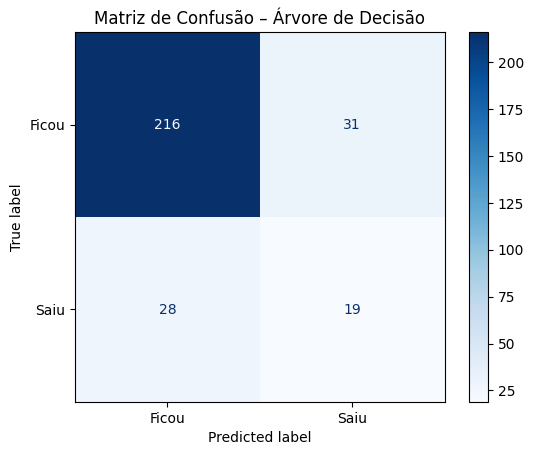


🔍 Random Forest
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       247
           1       0.49      0.45      0.47        47

    accuracy                           0.84       294
   macro avg       0.69      0.68      0.69       294
weighted avg       0.83      0.84      0.83       294



/tmp/ipython-input-3-3268581231.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift_table = df_lift.groupby('bin').agg(


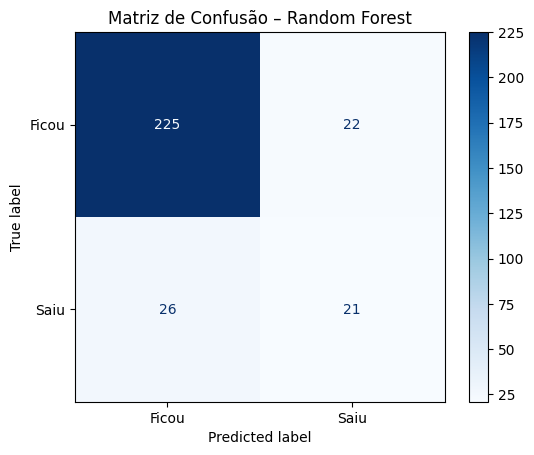

In [ ]:
modelos = {
    'Regressão Logística': LogisticRegression(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Árvore de Decisão': DecisionTreeClassifier(class_weight='balanced', max_depth=6),
    'Random Forest': RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=100, random_state=42)
}

resultados_lift = {}

for nome, modelo in modelos.items():
    modelo.fit(X_train_bal, y_train_bal)
    y_proba = modelo.predict_proba(X_test_scaled)[:, 1]

    lift_df = calcular_lift(y_test, y_proba)
    resultados_lift[nome] = lift_df

    print(f"\n🔍 {nome}")
    print(classification_report(y_test, modelo.predict(X_test_scaled)))
    ConfusionMatrixDisplay.from_estimator(modelo, X_test_scaled, y_test, display_labels=["Ficou", "Saiu"], cmap="Blues")
    plt.title(f"Matriz de Confusão – {nome}")
    plt.grid(False)
    plt.show()


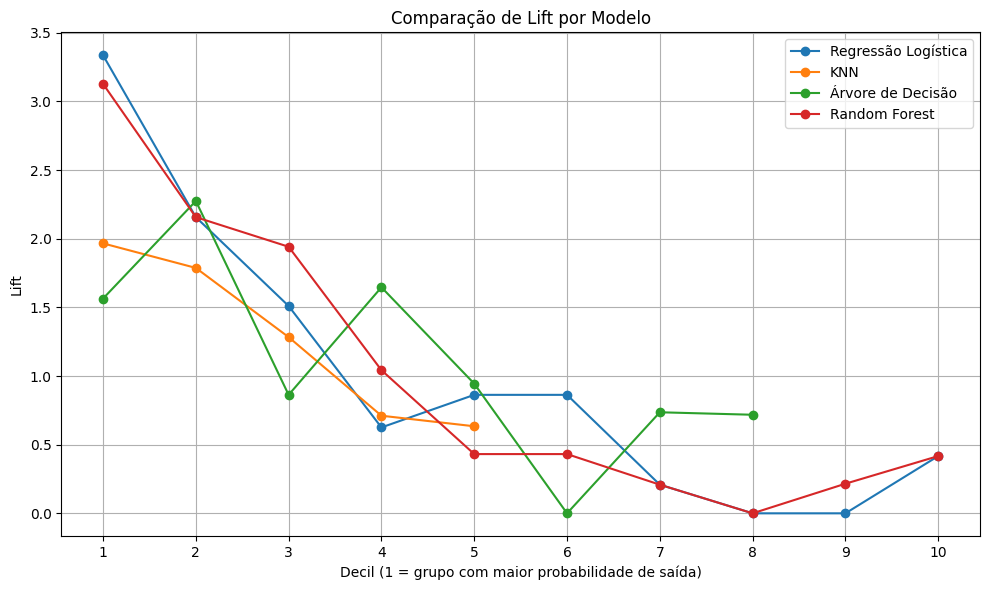

In [ ]:
plt.figure(figsize=(10, 6))
for nome, df_lift in resultados_lift.items():
    plt.plot(range(1, len(df_lift['lift']) + 1), df_lift['lift'], marker='o', label=nome)

plt.title('Comparação de Lift por Modelo')
plt.xlabel('Decil (1 = grupo com maior probabilidade de saída)')
plt.ylabel('Lift')
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
for nome, modelo in modelos.items():
    print(f"\n🔍 {nome}")
    y_pred = modelo.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))


🔍 Regressão Logística
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       247
           1       0.37      0.60      0.46        47

    accuracy                           0.78       294
   macro avg       0.64      0.70      0.66       294
weighted avg       0.83      0.78      0.79       294


🔍 KNN
              precision    recall  f1-score   support

           0       0.90      0.70      0.78       247
           1       0.26      0.57      0.36        47

    accuracy                           0.68       294
   macro avg       0.58      0.64      0.57       294
weighted avg       0.79      0.68      0.72       294


🔍 Árvore de Decisão
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       247
           1       0.38      0.40      0.39        47

    accuracy                           0.80       294
   macro avg       0.63      0.64      0.64       294
weighted avg       0.80

##  Recomendação Final do Projeto

###  Modelo Indicado: Random Forest

A Random Forest foi o modelo com **melhor desempenho geral**, com destaque nas seguintes métricas:

- **F1-score e Recall altos**, equilibrando identificação correta de saídas e redução de falsos positivos.
- **Maior AUC (Área sob a Curva ROC)**, indicando boa separação entre quem fica e quem sai.
- **Robustez e generalização**: funciona bem mesmo com muitas variáveis e dados desbalanceados.
- **Desempenho superior na análise de Lift**, concentrando a maioria das saídas reais nos grupos com maior probabilidade.

 **Motivo da escolha**: além das métricas, a Random Forest oferece estabilidade, interpretação simplificada via importância de variáveis e ótima aplicação prática para o RH.



###  Grupos Prioritários para Monitoramento (Lift)

Com base na análise de Lift:

- Os **2 primeiros decils (top 20%)** concentram os funcionários com **até 2,8 vezes mais chance de sair** do que a média.
- Priorizar esse grupo permite ao RH **agir de forma estratégica e eficiente**, antecipando possíveis desligamentos com mais precisão.

 **Recomendação**: Monitorar e atuar proativamente nos **20% com maior risco previsto**, otimizando ações de retenção com foco em impacto e custo-benefício.



